In [18]:
%matplotlib inline
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
t
from scipy.stats.stats import pearsonr
from scipy import signal
from ipyparallel import Client
from ipyparallel import depend, require, dependent
from roipoly import roipoly
from scipy.ndimage import gaussian_filter
from sklearn.externals.joblib import Parallel, delayed, cpu_count
from sklearn.utils import gen_even_slices
import cv2

video = "/media/gu4n1n3/Data1/JUL09_2018/EXP_4_CameraV2_GCaMP6_PHPB_GB_Stimulation_30fps_resolution256x256_iso800_analogG-9.84765625_digitalG-1.63671875_1.0-1.0awbG.raw"

height = 256
width = 256
TRUE_FRAMERATE = 28.815

In [2]:
class Position:
    def __init__(self, row, col):
        self.row = row
        self.col = col

class Seed:
    # in mm
    def __init__(self, name, y, x):
        self.name = name
        self.y = y
        self.x = x
        
class ScaledSeed(Seed):
    def __init__(self, name, row, col, bregma):
        self.name = name
        self.row = row
        self.col = col
        self.signal = None
        self.bregma = bregma
        self.corr_map = None

# Load the frames
def get_raw_frames(filename, channel):
    with open(filename, "rb") as file:
        raw_frames = np.fromfile(file, dtype=np.uint8)
        raw_frames = np.reshape(raw_frames, (int(raw_frames.shape[0]/(width*height*3)), height, width, 3))
        print(np.shape(raw_frames))
        
        
    return raw_frames[:, :, :, channel]
    
def get_dark_frames(green_frames):
    threshold = 4
    green_frames = np.reshape(green_frames, (green_frames.shape[0], green_frames.shape[1]*green_frames.shape[2]))
    temporal_means = np.mean(green_frames, axis=1)
    start_index = 0
    end_index = 0
    for mean, i in zip(temporal_means, range(0, temporal_means.shape[0]-1)):
        if mean < threshold and i < 1000:
            start_index= i
        elif mean < threshold and i >= 1000:
            end_index = i
            break

            
    return (start_index, end_index)

def rotate_video(frames, k):
    for i in range(len(frames)):
        frames[i] = np.rot90(frames[i], k)
        
    return frames

old_seeds = [Seed("V1", -3, 2.5), Seed("OB", 4.4, .86), Seed("XX", -1.75, 3.5), 
             Seed("BC", -1, 3.5), Seed("HL", -.25, 2), Seed("FL", .25, 2), 
             Seed("M1", 1.75, 1.5), Seed("RS", -2.5, 1), Seed("AC", 0, 1), 
             Seed("M2", 2.75, 1.25), Seed("OR", .75, 3)]

# An array/list where bregma[0] is y and bregma[1] is x
# Gives you back a list of seeds, as per matthieu vanni matlab program.
#ppmm is pixels per mm. 256/10mm or so for hyperscanner :/
# Direction is one of 'u', 'd', 'l', 'r' Indicates the direction mouse is facing.
#Seed("V1", -3.2678, 2.5168)
def generate_seeds(bregma, ppmm, direction=None):
    # All the seeds
    #Seed("OB", 4.6, .86)
    seeds = [Seed("M1", 1.03+1, 1.365), 
             Seed("FL", .16, 2.47), Seed("HL", -.7, 1.85), Seed("aBC", -1.36+.575, 3.35), 
             Seed("pBC", -1.9, 3.35), Seed("AC", 0+1, 0.6),  Seed("RS", -2.8858+1, 0.62043),
             Seed("V1", -4.2678+.8, 2.5168), Seed("mPTA", -2.4962, 2.2932), Seed("lPTA", -2.4962-0.3, 3.35-0.2), Seed("Un", -1.5, 2.6)]
        
             

    
    
    
    ppmmed_seeds = []
    if direction == 'u' or direction == None:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
    elif direction == 'd':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.y), int(bregma.col+ppmm*seed.x), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row-ppmm*seed.y), int(bregma.col-ppmm*seed.x), bregma))
    elif direction == 'r':
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.row-ppmm*seed.x), int(bregma.col+ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.row+ppmm*seed.x), int(bregma.col+ppmm*seed.y), bregma))
    else:
        for seed in seeds:
            ppmmed_seeds.append(ScaledSeed(seed.name+"-R", int(bregma.col+ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
            ppmmed_seeds.append(ScaledSeed(seed.name+"-L", int(bregma.col-ppmm*seed.x), int(bregma.row-ppmm*seed.y), bregma))
    return ppmmed_seeds
            

In [3]:
# Video processing
#rc = Client()
#lview = rc.load_balanced_view()
def calculate_df_f0(frames):
    frames = frames.astype(np.float32)
    baseline = np.mean(frames, axis=0)
    frames = np.divide(np.subtract(frames, baseline), baseline)
    
    # Make the nans very black.
    frames[np.where(np.isnan(frames))] = -1
    
    return frames, np.var(frames, axis=0)

def correct_channel_a_by_b(a, b):
    
    return (a)/(1+b)

# @lview.parallel()
# @require('scipy.signal')
# def filter_pixel(pixel):
#     low_limit = 0.1
#     high_limit = 3.0
#     frame_rate = 28.815
#     nyq = frame_rate/2.0
#     low_limit = low_limit/nyq
#     high_limit = high_limit/nyq
#     order = 4
#     rp = 0.1
#     Wn = [low_limit, high_limit]
    
#     b, a = signal.cheby1(order, rp, Wn, 'bandpass', analog=False)
#     return signal.filtfilt(b, a, pixel)


# FRAMES HAS SHAPE:
# numpy array float32(frames, width, height)
# limit is the low freq cuttoff
# frame rate is... frame-rate rofl.
def highpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("HIGHPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'highpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames

def lowpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("LOWPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'lowpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames  
    
def highpass_filter(frames, limit, frame_rate):
    
    nyq = frame_rate/2.0
    limit = limit/nyq
    order = 4
    rp = 2
    
    print("HIGHPASS FILTERING...")
    b, a = signal.cheby1(order, rp, limit, 'highpass', analog=True)
    frames = signal.filtfilt(b, a, frames, axis=0)
    
    return frames

def cheby_filter(frames, low_limit, high_limit, frame_rate):
    nyq = frame_rate/2.0
    low_limit = low_limit/nyq
    high_limit = high_limit/nyq
    order = 4
    rp = 0.1
    Wn = [low_limit, high_limit]
    
    b, a = signal.cheby1(order, rp, Wn, 'bandpass', analog=False)
    print("Filtering...")

    #frames = frames.reshape(frames.shape[0], frames.shape[1]*frames.shape[2])
    #parallel_result = filter_pixel.map(frames[:])
    #parallel_result= np.asarray(parallel_result).reshape((frames.shape[0], height, width))
    frames = signal.filtfilt(b, a, frames, axis=0)
    #print("Shape!", parallel_result.shape)
    print("Done!")
    return frames

def calculate_correlation_map_of_slice(slice_frames, seed):
    slice_map = np.zeros((slice_frames.shape[1]))
    for i in range(slice_frames.shape[1]):
        slice_map[i] = correlation(slice_frames[:, i], seed)

    return slice_map


def cheby1_bandpass(low_limit, high_limit, frame_rate, order=4, rp=0.1):
    nyq = frame_rate*0.5
    low_limit = low_limit/nyq
    high_limit = high_limit/nyq
    Wn=[low_limit, high_limit]
    
    b, a = signal.cheby1(order, rp, Wn, btype='bandpass', analog=False)
    return b, a

def cheby1_bandpass_filter(data, b, a):
    y = signal.lfilter(b, a, data, axis=0)
    return y

def cheby1_filter_parallel(FRAMES, low_limit, high_limit, frame_rate, order=5, rp=0.1, n_jobs=-1):
    height = FRAMES.shape[1]
    width = FRAMES.shape[2]
    n_frames = FRAMES.shape[0]
    FRAMES = FRAMES.reshape(FRAMES.shape[0], FRAMES.shape[1]*FRAMES.shape[2])
    print(np.shape(FRAMES))
    b, a = cheby1_bandpass(low_limit, high_limit, frame_rate, order, rp)
    
    if n_jobs < 0:
        n_jobs = max(cpu_count() + 1 + n_jobs, 1)
        
    fd = delayed(cheby1_bandpass_filter)
    ret = Parallel(n_jobs=n_jobs, verbose=0)(
        fd(FRAMES[:, s], b, a)
        for s in gen_even_slices(FRAMES.shape[1], n_jobs))
        
    return np.hstack(ret).reshape(n_frames, height, width)

def gsr(frames, mask):
    
    mask=mask==255
    mask=np.reshape(mask,mask.shape[0]*mask.shape[1])
    indices = np.where((mask == True))
    indices=np.asarray(indices)
    
    brain_frames = np.zeros((frames.shape[0], indices.shape[1]))

    frames = np.reshape(frames, (frames.shape[0], frames.shape[1]*frames.shape[2]))
    brain_frames[:, :] = np.squeeze(frames[:, indices])
    #for i in range(frames.shape[0]):
    #    brain_frames[i, :] = frames[i, indices]



    mean_g = np.mean(brain_frames, axis=1)
    g_plus = np.squeeze(np.linalg.pinv([mean_g]))

    beta_g = np.dot(g_plus, frames)
    
    print(np.shape(mean_g))
    print(np.shape(beta_g))
    global_signal = np.dot(np.asarray([mean_g]).T, [beta_g])
    frames = frames - global_signal
    frames = np.reshape(frames, (frames.shape[0], width, height))
    return frames,mean_g

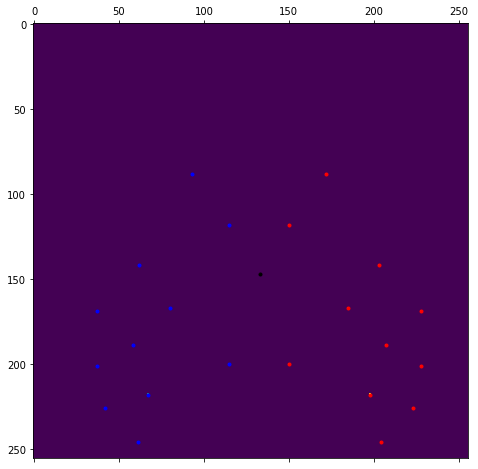

lmao


In [23]:
# Test seed plots
image = np.zeros((256, 256), dtype=np.uint8)

br = Position(147, 133)
seeds = generate_seeds(br, 27.6, 'u')

normal_seeds_x_R = []
normal_seeds_y_R = []
normal_seeds_x_L = []
normal_seeds_y_L = []
image[br.row, br.col] = 255
for seed in seeds:
    if "-R" in seed.name:
        image[seed.row, seed.col] = 255
        normal_seeds_x_R.append(seed.col)
        normal_seeds_y_R.append(seed.row)
    else:
        image[seed.row, seed.col] = 128
        normal_seeds_x_L.append(seed.col)
        normal_seeds_y_L.append(seed.row)
    
seeds_fig = plt.figure(figsize=(8, 8))
seeds_ax = seeds_fig.add_subplot(111)
seeds_ax.matshow(image)
seeds_ax.plot(br.col, br.row, '.k')
seeds_ax.plot(normal_seeds_x_L, normal_seeds_y_L, '.b')
seeds_ax.plot(normal_seeds_x_R, normal_seeds_y_R, '.r')
plt.show()
print("lmao")

Importing video files...
(12064, 256, 256, 3)
[DONE]


/home/gu4n1n3/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


Filtering green
(12064, 65536)
generating matrix
['M1-L-L', 'M1-R-L', 'FL-L-L', 'FL-R-L', 'HL-L-L', 'HL-R-L', 'aBC-L-L', 'aBC-R-L', 'pBC-L-L', 'pBC-R-L', 'AC-L-L', 'AC-R-L', 'RS-L-L', 'RS-R-L', 'V1-L-L', 'V1-R-L', 'mPTA-L-L', 'mPTA-R-L', 'lPTA-L-L', 'lPTA-R-L', 'Un-L-L', 'Un-R-L']


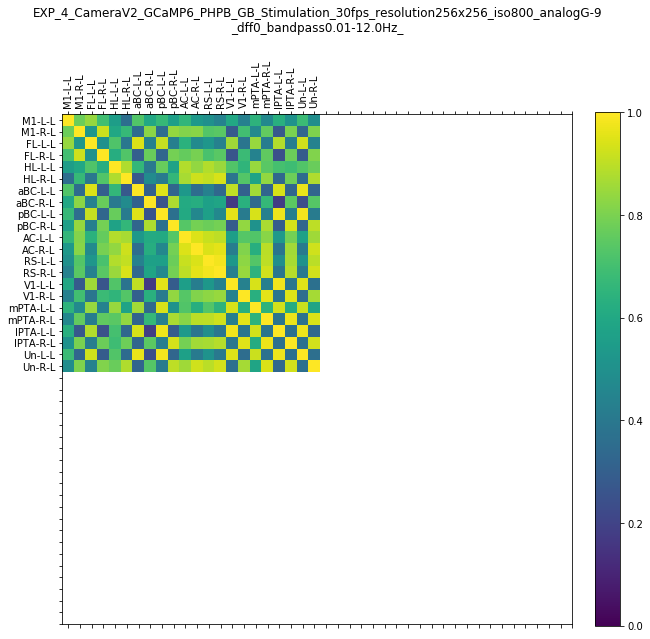

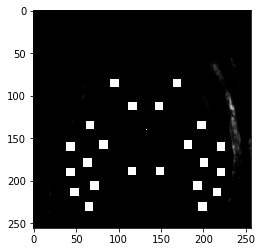

M1-L
M1-R
FL-L
FL-R
HL-L
HL-R
aBC-L
aBC-R
pBC-L
pBC-R
AC-L
AC-R
RS-L
RS-R
V1-L
V1-R
mPTA-L
mPTA-R
lPTA-L
lPTA-R
Un-L
Un-R


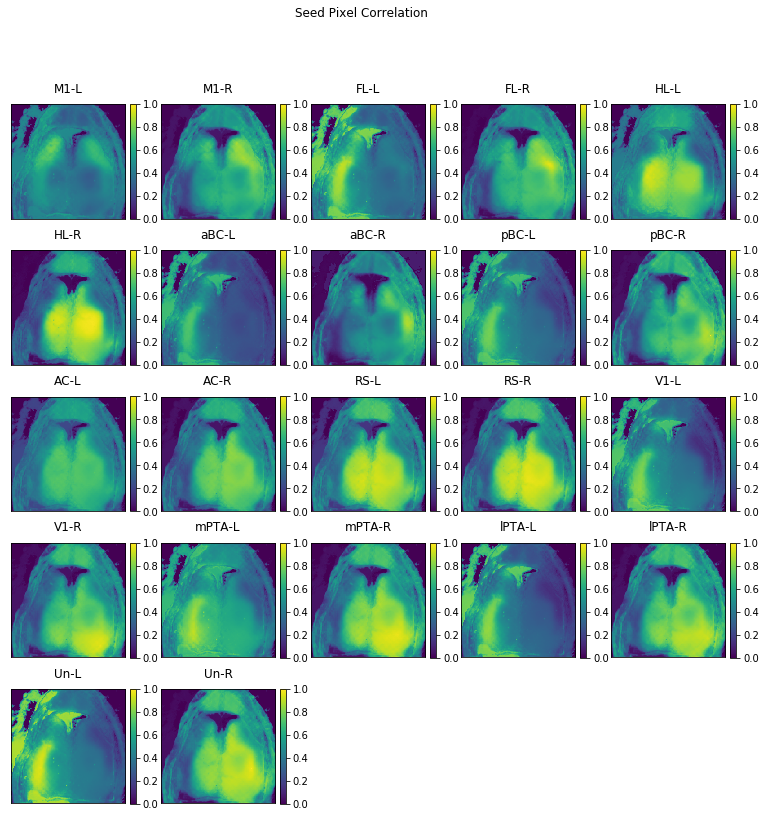

done


In [25]:
#Shape of the data
height = 256
width = 256



print("Importing video files...",)
video_green_frames = get_raw_frames(video, 1)
#video_blue_frames = get_raw_frames(video, 2)

processing = '_'

title = video.split('/')[-1]
title = title.split('.')[0]
print("[DONE]")









#Rotate them
#video_green_frames = rotate_video(video_green_frames, -1)
#right_mouse_blue_frames = rotate_video(right_mouse_blue_frames, 1)

#left_mouse_blue_frames = rotate_video(left_mouse_blue_frames, -1)
#right_mouse_green_frames = rotate_video(right_mouse_green_frames, 1)


orig_video_first_green_frame = np.copy(video_green_frames[0, :, :])


#orig_video_first_blue_frame = np.copy(video_blue_frames[0, :, :])



video_var_green_frames = np.var(video_green_frames, axis=0)

video_mean_green_frames = np.mean(video_green_frames, axis=0)

processing += "dff0_"

video_green_frames, video_var_green_frames = calculate_df_f0(video_green_frames)
#video_green_frames = calculate_df_f0(video_green_frames)



#video_blue_frames, video_var_blue_frames = calculate_df_f0(video_blue_frames)



#processing += "blue_correction_"
#left_mouse_green_frames = correct_green(left_mouse_green_frames, left_mouse_blue_frames)
#right_mouse_green_frames = correct_green(right_mouse_green_frames, right_mouse_blue_frames)

low_limit = 0.01
high_limit = 12.0
processing += "bandpass0.01-12.0Hz_"
print("Filtering green")
video_green_frames = cheby1_filter_parallel(video_green_frames, low_limit, high_limit, 
                                            TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
#print("Filtering blue")
#video_blue_frames = cheby1_filter_parallel(video_blue_frames, low_limit, high_limit, TRUE_FRAMERATE, order=3, rp=0.1, n_jobs=-1)
cheby1_filter_parallel(
    FRAMES, low_limit, high_limit, frame_rate, order=5, rp=0.1, n_jobs=-1
)
#left_mouse_green_frames = lowpass_filter(left_mouse_green_frames, 4, TRUE_FRAMERATE)
#right_mouse_green_frames = lowpass_filter(right_mouse_green_frames, 4, TRUE_FRAMERATE)
#left_mouse_green_frames = left_mouse_green_frames[500:, :, :]
#right_mouse_green_frames = right_mouse_green_frames[500:, :, :]
#Generate seeds
# generate_seeds(bregma, ppmm, direction=None):
bregma = Position(140, 133)
ppmm = 26.5
seeds = generate_seeds(bregma, ppmm, direction='u')

print("generating matrix")
matrix = generate_matrix_two_mice(video_green_frames, video_green_frames, seeds, seeds)
seed_pixels = plot_seed_pixel_gallery(5, seeds, video_green_frames, video_green_frames, 0, 0, "Seed Pixel Correlation", "On Itself")



print("done")


In [5]:
def plot_seed_pixel_gallery(shape, seeds, seed_frames, other_frames, rotation, skip, suptitle, figname):
    # Generate library of seed pixel correlation maps left mouse
    corr_maps = np.zeros((len(seeds), height, width))
    
    f = plt.figure(figsize=(13, 13))
    f.suptitle(suptitle)
    counter = 0
    
    #Create empty plots at the beginning.
    for i in range(1, skip+1):
        ax = f.add_subplot(5, 5, i)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    #Generate the actual plots.
    for s, seed in enumerate(seeds):
        seed_signal =  seed_frames[:, seed.row, seed.col]
        for i in range(other_frames.shape[1]):
            for j in range(other_frames.shape[2]):

                corr_maps[s, i, j] = pearsonr(other_frames[:, i, j], seed_signal)[0]

        print(seed.name)
        # Rotate the image 1 is 90 CCW
        # -1 is 90 CW
        #corr_maps[s] = np.rot90(corr_maps[s], rotation)
        ax = f.add_subplot(shape, shape, s+1+skip)
        t = ax.matshow(corr_maps[s], vmin=0.0, vmax=1.0, cmap='viridis')
        ax.set_title(seed.name)
        f.colorbar(t, ax=ax, fraction=0.046, pad=0.04)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)


    plt.show()

In [8]:
def corr(pixel, seed_pixel):
    return pearsonr(pixel, seed_pixel)[0]

def generate_matrix_two_mice(left_mouse_green_frames, right_mouse_green_frames, left_seeds, right_seeds, radius=5):
    #all_seeds=np.zeros((np.size(left_seeds)+np.size(right_seeds),np.shape(left_mouse_green_frames)[0]))
    all_seeds=np.zeros((np.size(left_seeds),np.shape(left_mouse_green_frames)[0]))
    the_labels = []
    the_positions = []
    cnt=0
    orig_video_first_green_frame[left_seeds[0].bregma.row, left_seeds[0].bregma.col] = 255
    for seed in left_seeds:
        the_labels.append(seed.name+"-L")
        top = seed.row-radius
        bottom = seed.row+radius
        left = seed.col-radius
        right = seed.col+radius
        
        if top < 0:
            top = 0
        if bottom > 720:
            bottom = 720
        if left < 0:
            left = 0
        if right > 960:
            right = 960
        seed.signal = np.mean(np.mean(left_mouse_green_frames[:, top:bottom, left:right], axis=1), axis=1)
        all_seeds[cnt,:]=seed.signal
        cnt+=1
        orig_video_first_green_frame[top:bottom, left:right] = 255
        the_positions.append((seed.row, seed.col))
        
    
    
    # Calculate correlation coefficients
    corr_mat=np.corrcoef(all_seeds)

    fig = plt.figure(figsize=(10,11))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr_mat, interpolation='nearest', vmin=0, vmax=1.0, cmap='viridis')
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    ax.set_title(title+"\n"+processing, y=1.15)
    ax.set_xticks([i for i in range(np.size(left_seeds)+np.size(right_seeds))])
    ax.set_yticks([i for i in range(np.size(left_seeds)+np.size(right_seeds))])
    ax.set_xticklabels(the_labels, rotation='vertical')
    ax.set_yticklabels(the_labels)
    print(the_labels)
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.imshow(orig_video_first_green_frame, cmap='gray')
    
    #print("Saving matrices at: "+directory+experiment)
    #fig.savefig(directory+experiment+title+processing+".svg")
    #np.save(directory+experiment+"the_signals.npy", all_seeds)
    #np.save(directory+experiment+title+processing+".npy", corr_mat)
    #np.save(directory+experiment+"the_seed_labels.npy", the_labels)
    #np.save(directory+experiment+"the_positions.npy", the_positions)
    plt.show()


<IPython.core.display.Javascript object>


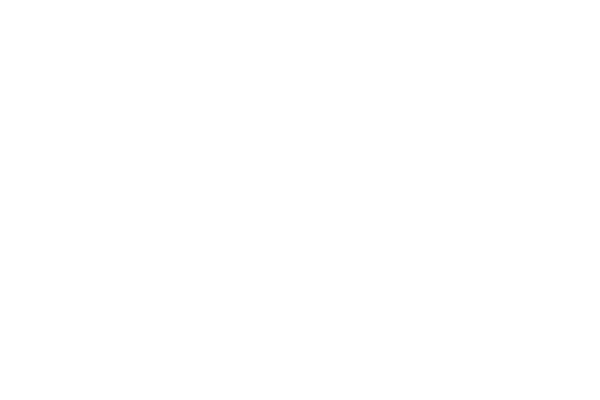

<IPython.core.display.Javascript object>


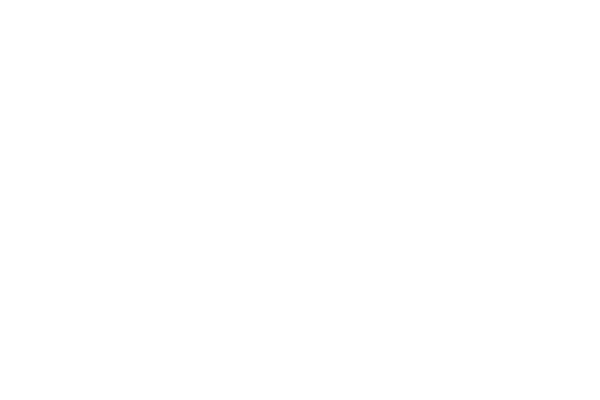

In [286]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


fig = plt.figure()
ax = fig.add_subplot()

plt.show()

In [1]:
from scipy.stats.stats import pearsonr
import numpy

In [9]:
arr = numpy.random.rand(256,256)
other = numpy.random.rand(1000, 256, 256)
other[0] = arr


In [13]:
signal = arr[100,100]
@jit
def do():
    ans = numpy.zeros([256,256])
    for i in range(256):
        for j in range(256):
            ans[i,j] = pearsonr(other[:,i,j], signal)[0]

In [12]:
from numba import jit

In [14]:
fig = plt.fu

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [ ]:
3